# VISUALIZE DEVELOPED COUNTRIES AND INDIA

Import the libraries

In [1]:
from pyspark.sql.functions import *
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.pyplot import figure
import numpy as np
from __future__ import division
%matplotlib inline

Import the dataset from the file system

In [2]:
GDP_dataset = 'Spark_Dataset/GDP/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10134290/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10134290.csv'
HDI_dataset = 'Spark_Dataset/HDI/Human Development Index (HDI).csv'
Infant_Mortality_dataset = 'Spark_Dataset/Infant_Mortality_Rate/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_10181276/API_SP.DYN.IMRT.IN_DS2_en_csv_v2_10181276.csv'
Life_Expectancy_dataset = 'Spark_Dataset/Life_Expectancy/API_SP.DYN.LE00.IN_DS2_en_csv_v2_10181296/API_SP.DYN.LE00.IN_DS2_en_csv_v2_10181296.csv'
Population_dataset = 'Spark_Dataset/Population/API_SP.POP.TOTL_DS2_en_csv_v2_10203548/API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv'

Define a function which returns a list of 33 developed countries as per per CIA (https://www.cia.gov/library/publications/the-world-factbook/appendix/appendix-b.html#D)

NOTE: 
1. Taiwan data doesnt exist in the world bank database. So, ommitted.
2. Hong Kong data doesnt exist in the world bank database for Infant Mortality Rate. So, ommitted.
3. Korea data doesnt exist. So, ommitted.

In [3]:
def developed_countries_list():
    dc_list = []
    dc_list.append("Australia")
    dc_list.append("Austria")
    dc_list.append("Belgium")
    dc_list.append("Canada")
    dc_list.append("Cyprus")
    dc_list.append("Czech Republic")
    dc_list.append("Denmark")
    dc_list.append("Finland")
    dc_list.append("France")
    dc_list.append("Germany")
    dc_list.append("Greece")
    #dc_list.append("Hong Kong SAR, China")
    dc_list.append("Iceland")
    dc_list.append("Ireland")
    dc_list.append("Israel")
    dc_list.append("Italy")
    dc_list.append("Japan")
    #dc_list.append("Korea, Rep.")
    dc_list.append("Luxembourg")
    dc_list.append("Malta")
    dc_list.append("Netherlands")
    dc_list.append("New Zealand")
    dc_list.append("Norway")
    dc_list.append("Portugal")
    dc_list.append("Singapore")
    dc_list.append("Slovak Republic")
    dc_list.append("Slovenia")
    dc_list.append("Spain")
    dc_list.append("Sweden")
    dc_list.append("Switzerland")
    #dc_list.append("Taiwan")
    dc_list.append("United Kingdom")
    dc_list.append("United States")
    return dc_list

Define a function that can get the indexes from the dataframe

In [4]:
def addColumnIndex(df): 
    oldColumns = df.schema.names
    newColumns = oldColumns + ["columnindex"]
    df_indexed = df.rdd.zipWithIndex().map(lambda (row, columnindex): \
                                         row + (columnindex,)).toDF(newColumns)   
    return df_indexed

Get the dataframes from the csv files

In [5]:
gdp_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(GDP_dataset)
hdi_df = spark.read.option('header','true').option('inferSchema','true').csv(HDI_dataset)
im_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Infant_Mortality_dataset)
le_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Life_Expectancy_dataset)
pop_df = spark.read.option('header','true').option('sep', '\t').option('inferSchema','true').csv(Population_dataset)

For the **hdi_df** dataframe:
1. Filter NAN columns which are alternate
2. Remove the space from the name of the countries in the Country column
3. Rename the countries which have different name in the other dataframes to make data same throughout
4. Add INDIA to the list of countries so as to make an analysis with other countries.

In [6]:
hdi_drop_col = []
for i in range(3,len(hdi_df.schema.names)):
    if(i%2 == 1):
        hdi_drop_col.append(hdi_df.schema.names[i])
hdi_df = hdi_df.withColumn('Country', ltrim(hdi_df.Country))
hdi_df = hdi_df.select([column for column in hdi_df.columns if column not in hdi_drop_col])
hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Czechia', 'Czech Republic'))
#hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Hong Kong, China (SAR)', 'Hong Kong SAR, China'))
#hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Korea (Republic of)', 'Korea, Rep.'))
hdi_df = hdi_df.withColumn('Country', regexp_replace('Country', 'Slovakia', 'Slovak Republic'))

Filter all the dataframes with the countries that are in the list : countries_list and India

In [7]:
# Get the list of all developed countries   
countries_list = developed_countries_list()
# Add India among other countries for comparison and analysis
countries_list.append("India")

developed_gdp_df = gdp_df.filter(col('Country Name').isin(countries_list))
developed_im_df = im_df.filter(col('Country Name').isin(countries_list))
developed_le_df = le_df.filter(col('Country Name').isin(countries_list))
developed_hdi_df = hdi_df.filter(col('Country').isin(countries_list))
developed_pop_df = pop_df.filter(col('Country Name').isin(countries_list))

Drop the redundant columns data

In [8]:
drop_cols_n = range(1960,1995)
drop_cols_n.append(2017)
drop_cols_s = [str(i) for i in drop_cols_n]

Filter population data from 1995 - 2016 <br/>
Transpose the data

In [9]:
developed_pop_df = developed_pop_df.select([column for column in developed_pop_df.columns if column not in drop_cols_s])
developed_pop_df = developed_pop_df.select([column for column in developed_pop_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_pop_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_pop_df2 = developed_pop_df.select([c for c in developed_pop_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_pop_rdd = developed_pop_df2.rdd.map(tuple)

# Transpose Data
developed_pop_rddT1 = developed_pop_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_pop_rddT2 = developed_pop_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_pop_rddT3 = developed_pop_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_pop_rddT4 = developed_pop_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_pop_transposed_df = developed_pop_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_pop_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = 1000000000 #developed_pop_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_pop_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_pop_transposed_df = developed_pop_transposed_df.withColumn(name, col(name)/divider)

Filter GDP data from 1995 - 2016 <br/>
Transpose the data

In [10]:
developed_gdp_df = developed_gdp_df.select([column for column in developed_gdp_df.columns if column not in drop_cols_s])
developed_gdp_df = developed_gdp_df.select([column for column in developed_gdp_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_gdp_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_gdp_df2 = developed_gdp_df.select([c for c in developed_gdp_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_gdp_rdd = developed_gdp_df2.rdd.map(tuple)

# Transpose Data
developed_gdp_rddT1 = developed_gdp_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_gdp_rddT2 = developed_gdp_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_gdp_rddT3 = developed_gdp_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_gdp_rddT4 = developed_gdp_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_gdp_transposed_df = developed_gdp_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_gdp_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = 1000000000 #developed_gdp_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_gdp_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_gdp_transposed_df = developed_gdp_transposed_df.withColumn(name, col(name)/divider)

Filter IMR data from 1995 - 2016 <br/>
Transpose the data

In [11]:
developed_im_df = developed_im_df.select([column for column in developed_im_df.columns if column not in drop_cols_s])
developed_im_df = developed_im_df.select([column for column in developed_im_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_im_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_im_df2 = developed_im_df.select([c for c in developed_im_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_im_rdd = developed_im_df2.rdd.map(tuple)

# Transpose Data
developed_im_rddT1 = developed_im_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_im_rddT2 = developed_im_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_im_rddT3 = developed_im_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_im_rddT4 = developed_im_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_im_transposed_df = developed_im_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_im_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = developed_im_transposed_df.agg({name: "max"}).collect()[0][0]
#        #developed_im_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_im_transposed_df = developed_im_transposed_df.withColumn(name, col(name)/divider)

Filter LER data from 1995 - 2016 <br/>
Transpose the data

In [12]:
developed_le_df = developed_le_df.select([column for column in developed_le_df.columns if column not in drop_cols_s])
developed_le_df = developed_le_df.select([column for column in developed_le_df.columns if column not in ['Country Code','Indicator Name','Indicator Code']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_le_df.select("Country Name").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_le_df2 = developed_le_df.select([c for c in developed_le_df.columns if c not in ['Country Name']])

# Convert DataFrame to RDD
developed_le_rdd = developed_le_df2.rdd.map(tuple)

# Transpose Data
developed_le_rddT1 = developed_le_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_le_rddT2 = developed_le_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_le_rddT3 = developed_le_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_le_rddT4 = developed_le_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_le_transposed_df = developed_le_rddT4.toDF(new_header)

#Normalize the columns
#for field in developed_le_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = developed_le_transposed_df.agg({name: "max"}).collect()[0][0]
#        #developed_le_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_le_transposed_df = developed_le_transposed_df.withColumn(name, col(name)/divider)

Filter HDI data from 1995 - 2016 <br/>
Transpose the data

In [13]:
developed_hdi_df = developed_hdi_df.select([column for column in developed_hdi_df.columns if column not in drop_cols_s])
developed_hdi_df = developed_hdi_df.select([column for column in developed_hdi_df.columns if column not in ['HDI Rank (2017)']])

# Grad data from first columns, since it will be transposed to new column headers
new_header = [i[0] for i in developed_hdi_df.select("Country").rdd.map(tuple).collect()]

# Remove first column from dataframe
developed_hdi_df2 = developed_hdi_df.select([c for c in developed_hdi_df.columns if c not in ['Country']])

# Convert DataFrame to RDD
developed_hdi_rdd = developed_hdi_df2.rdd.map(tuple)

# Transpose Data
developed_hdi_rddT1 = developed_hdi_rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
developed_hdi_rddT2 = developed_hdi_rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
developed_hdi_rddT3 = developed_hdi_rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
developed_hdi_rddT4 = developed_hdi_rddT3.map(lambda x: map(lambda (i, y): y , x))

# Convert back to DataFrame (along with header)
developed_hdi_transposed_df = developed_hdi_rddT4.toDF(new_header)
#developed_hdi_transposed_df.show()

#Normalize the columns
#for field in developed_hdi_transposed_df.schema.fields:
#    if str(field.dataType) in ['DoubleType', 'FloatType', 'LongType', 'IntegerType', 'DecimalType']:
#        name = str(field.name)
#        divider = developed_hdi_transposed_df.agg({name: "max"}).collect()[0][0]
        #developed_gdp_transposed_df.groupBy().sum().collect()[0]["sum("+name+")"]
#        developed_hdi_transposed_df = developed_hdi_transposed_df.withColumn(name, col(name)/divider)

Index all the data

In [14]:
final_pop_pd_df = developed_pop_transposed_df.toPandas()
final_pop_pd_df.index = range(1995,2017)

final_gdp_pd_df = developed_gdp_transposed_df.toPandas()
final_gdp_pd_df.index = range(1995,2017)

final_im_pd_df_ni = developed_im_transposed_df.toPandas()
final_im_pd_df_ni.index = range(1995,2017)
final_im_pd_df = np.power(final_im_pd_df_ni,-1) 

final_le_pd_df = developed_le_transposed_df.toPandas()
final_le_pd_df.index = range(1995,2017)

final_hdi_pd_df = developed_hdi_transposed_df.toPandas()
final_hdi_pd_df.index = range(1995,2017)

Get the GDP per capita

In [15]:
final_gdp_perc_pd_df = pd.DataFrame().reindex_like(final_gdp_pd_df)
for i in range(0,final_gdp_perc_pd_df.shape[0]):
    i = i+1995
    for j in range(0,final_gdp_perc_pd_df.columns.shape[0]):
        gdp_val = final_gdp_pd_df.loc[i, final_gdp_pd_df.columns[j]]
        pop_val = final_pop_pd_df.loc[i, final_pop_pd_df.columns[j]]
        final_gdp_perc_pd_df.loc[i, final_gdp_perc_pd_df.columns[j]] = gdp_val/pop_val

Sum all the dataframes using weights to get a final dataframe

In [16]:
gdp_pc_factor = 0.0001
im_factor = 1
le_factor = 1
hdi_factor = 10

final_pd_dfs = [gdp_pc_factor*final_gdp_perc_pd_df,im_factor*final_im_pd_df,le_factor*final_le_pd_df,hdi_factor*final_hdi_pd_df]
final_df = reduce(lambda x, y: x.add(y, fill_value=0), final_pd_dfs)

# DATA VISUALIZATION

Plot of Developed Countries and India using the weighted sum of all the factors.

Text(0,0.5,'Development Quotient')

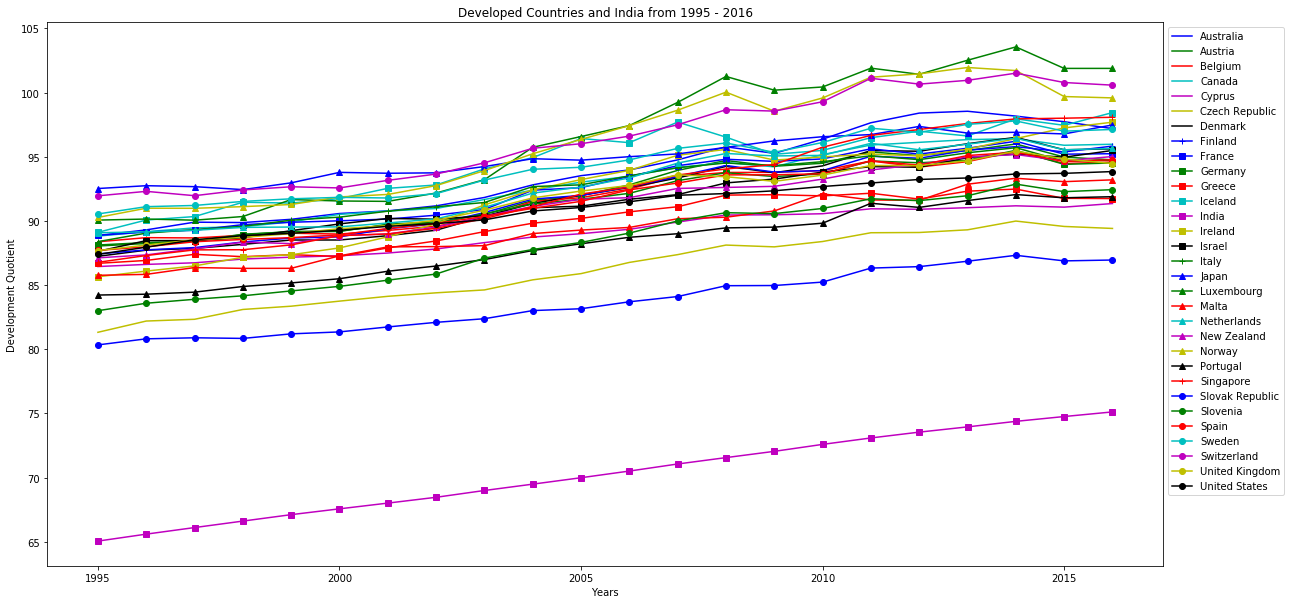

In [17]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax1 = final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset)
ax1.legend(bbox_to_anchor=(1, 1))
ax1.set_xlabel("Years")
ax1.set_ylabel("Development Quotient")

Plot of Developed Countries and India in terms of Population

Text(0,0.5,'Population')

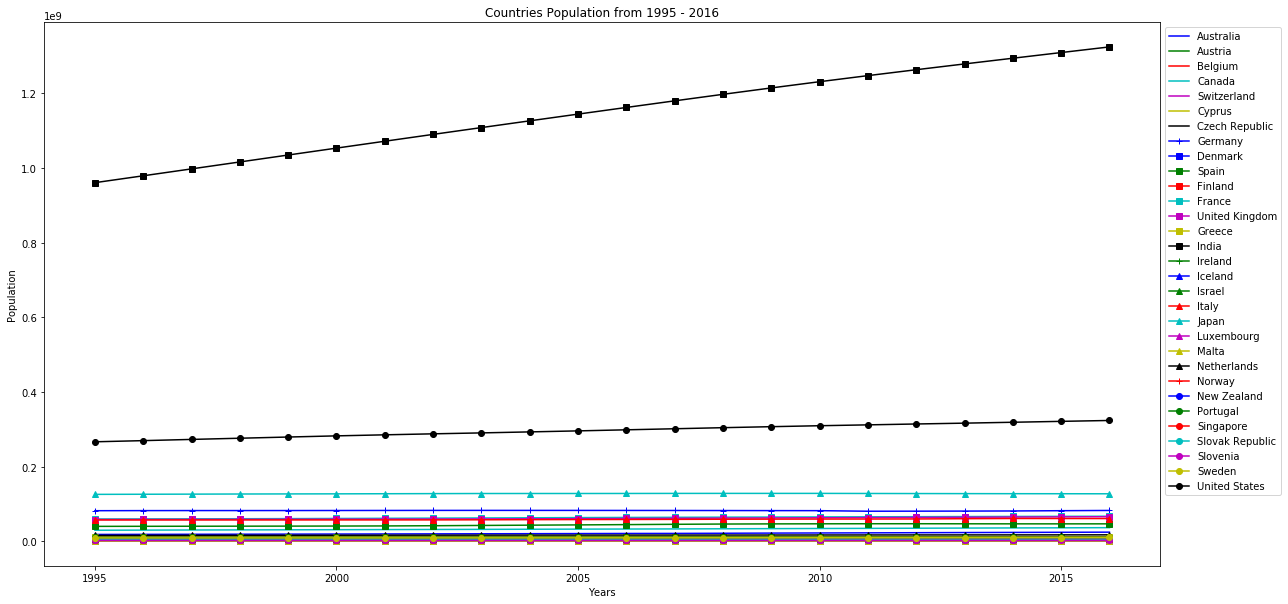

In [18]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax5 = final_pop_pd_df.plot(title="Countries Population from 1995 - 2016",figsize=(20,10),style=colorset)
ax5.legend(bbox_to_anchor=(1, 1))
ax5.set_xlabel("Years")
ax5.set_ylabel("Population")

Plot of Developed Countries and India in terms of GDP

Text(0,0.5,'GDP')

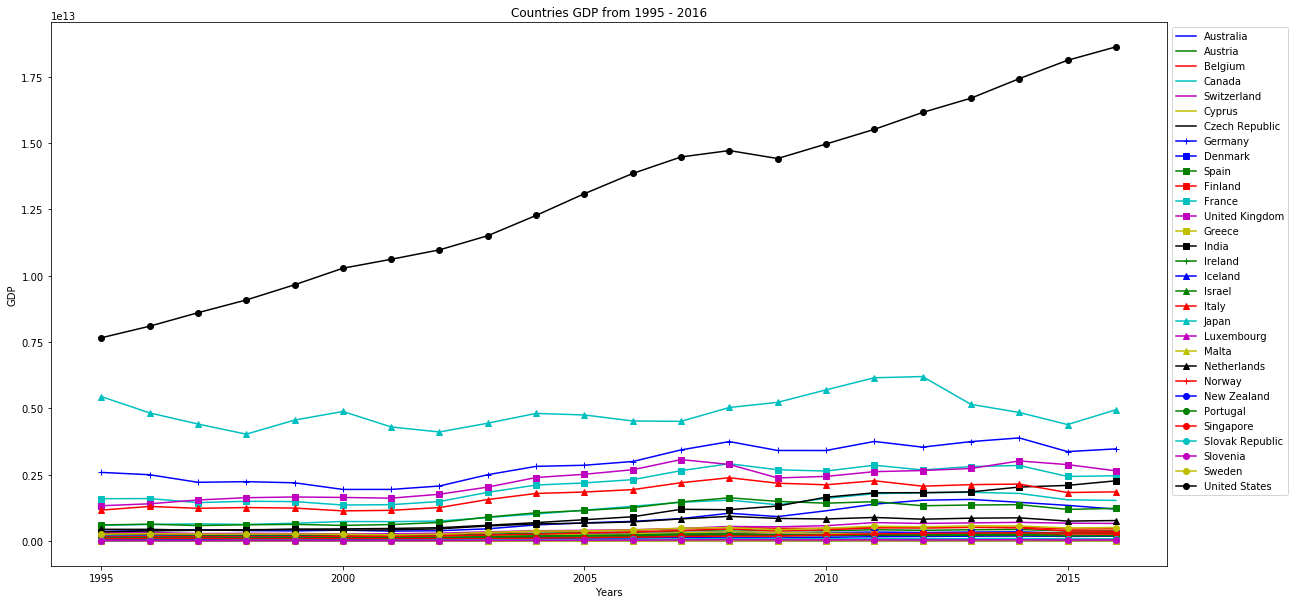

In [19]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax6 = final_gdp_pd_df.plot(title="Countries GDP from 1995 - 2016",figsize=(20,10),style=colorset)
ax6.legend(bbox_to_anchor=(1, 1))
ax6.set_xlabel("Years")
ax6.set_ylabel("GDP")

Plot of Developed Countries and India in terms of GDP per capita

Text(0,0.5,'GDP per capita')

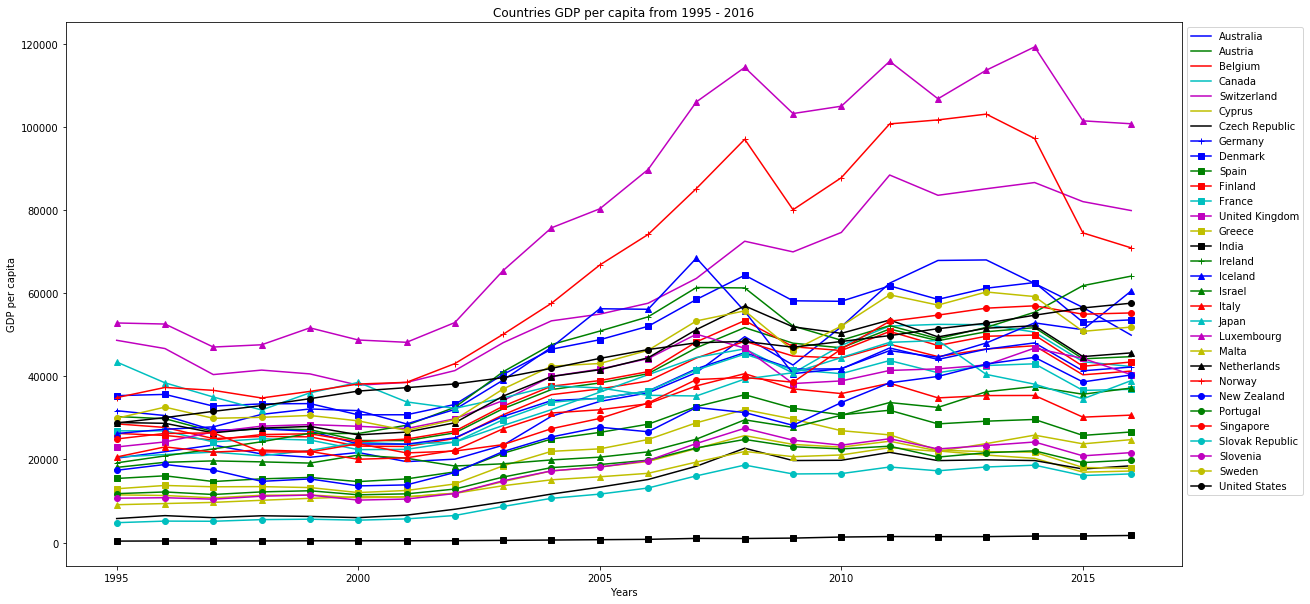

In [20]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax2 = final_gdp_perc_pd_df.plot(title="Countries GDP per capita from 1995 - 2016",figsize=(20,10),style=colorset)
ax2.legend(bbox_to_anchor=(1, 1))
ax2.set_xlabel("Years")
ax2.set_ylabel("GDP per capita")

Plot of Developed Countries and India in terms of HDI

Text(0,0.5,'Human Development Index')

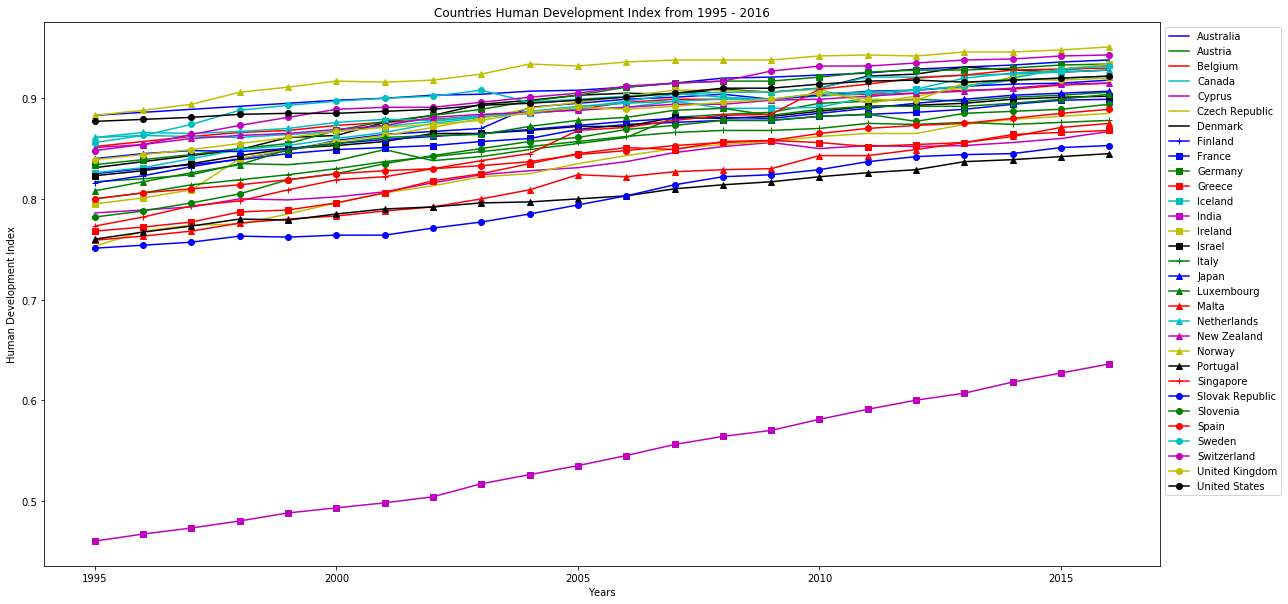

In [21]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax0 = final_hdi_pd_df.plot(title="Countries Human Development Index from 1995 - 2016",figsize=(20,10),style=colorset)
ax0.legend(bbox_to_anchor=(1, 1))
ax0.set_xlabel("Years")
ax0.set_ylabel("Human Development Index")

Plot of Developed Countries and India in terms of IMR

Text(0,0.5,'Infant Mortality Rate')

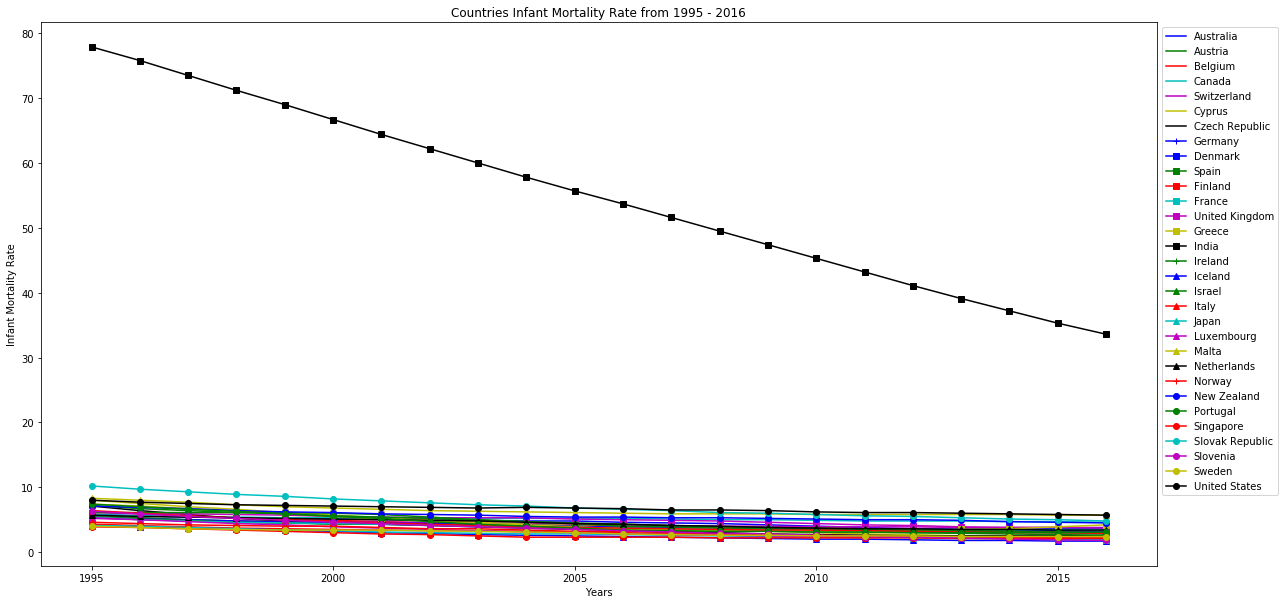

In [22]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax3 = final_im_pd_df_ni.plot(title="Countries Infant Mortality Rate from 1995 - 2016",figsize=(20,10),style=colorset)
ax3.legend(bbox_to_anchor=(1, 1))
ax3.set_xlabel("Years")
ax3.set_ylabel("Infant Mortality Rate")

Plot of Developed Countries and India in terms of LER

Text(0,0.5,'Life Expectancy Rate')

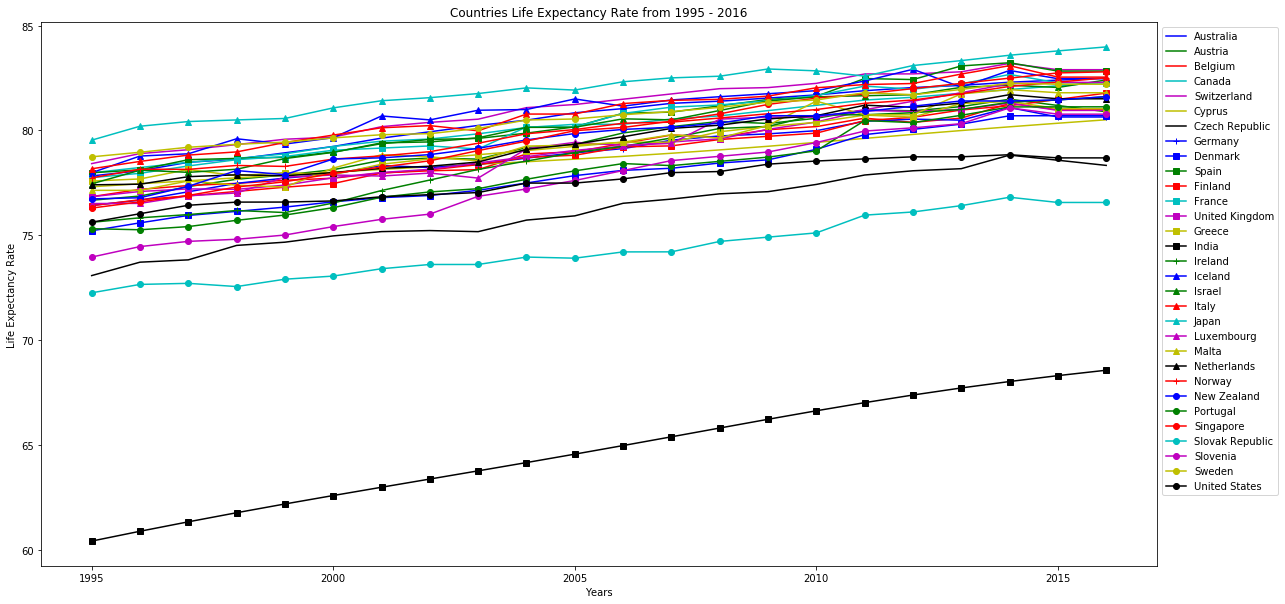

In [23]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax4 = final_le_pd_df.plot(title="Countries Life Expectancy Rate from 1995 - 2016",figsize=(20,10),style=colorset)
ax4.legend(bbox_to_anchor=(1, 1))
ax4.set_xlabel("Years")
ax4.set_ylabel("Life Expectancy Rate")

Plot of Developed Countries and India in terms of GDP from 2009 to 2011 showing the dip in GDP during the economic meltdown in 2008-09

Text(0,0.5,'GDP')

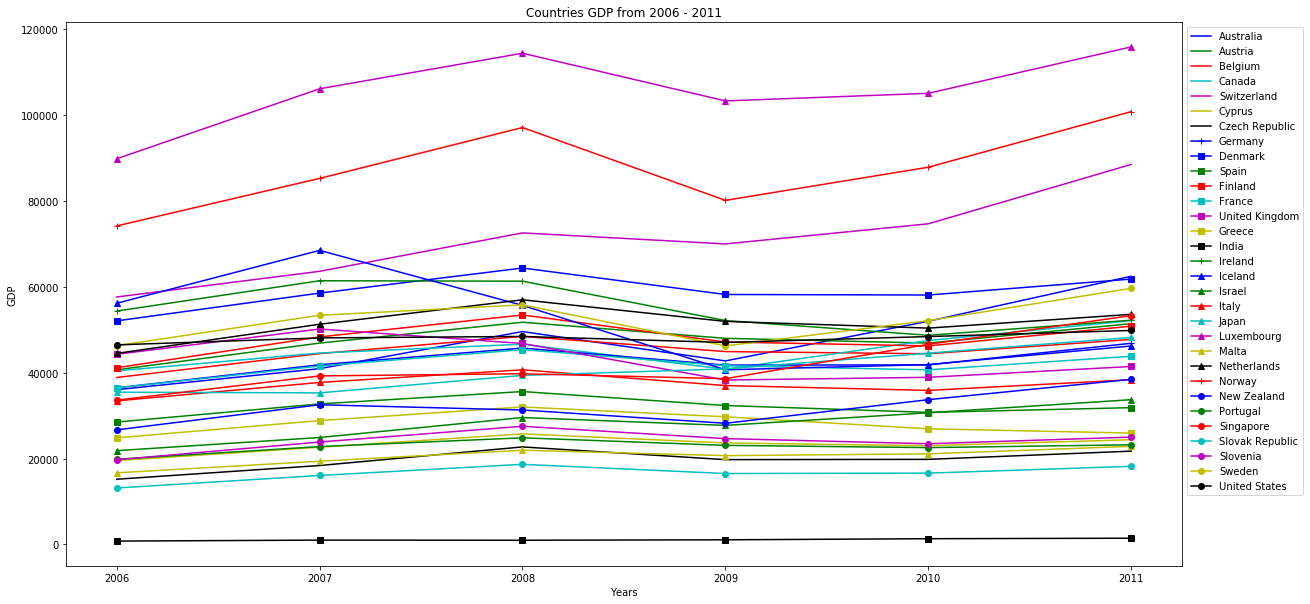

In [24]:
colorset = ['b-','g-','r-','c-','m-','y-','k-','b+-','bs-','gs-','rs-','cs-','ms-','ys-','ks-','g+-','b^-','g^-','r^-','c^-','m^-','y^-','k^-','r+-','bo-','go-','ro-','co-','mo-','yo-','ko-','c+-']
#final_df.plot(title="Developed Countries and India from 1995 - 2016",figsize=(20,10),style=colorset).legend(bbox_to_anchor=(1, 1))
ax7 = final_gdp_perc_pd_df[11:17].plot(title="Countries GDP from 2006 - 2011",figsize=(20,10),style=colorset)
ax7.legend(bbox_to_anchor=(1, 1))
ax7.set_xlabel("Years")
ax7.set_ylabel("GDP")